<a href="https://colab.research.google.com/github/ednavivianasegura/ERAP_Curso_R/blob/main/ERAP_R_Course_ModuloII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Título**:  Manipulación de datos con R  - Módulo II (Manejo de datos desordenados y falta de información )                               
                                          
**Autor(es)**:  Edna Viviana Segura Alvarado - Hans Mauricio Carrillo Hernández

**Fecha**: 2025-06

**Institución**: Universidad de La Rioja    

# ¿Qué son los datos faltantes (Missing Data)?

En R, los valores no disponibles o faltantes se representan con NA (Not Available en inglés) y pueden surgir por múltiples motivos:

- errores de registro
- fallos de instrumentos
- no respuesta en encuestas
- entre otros.

(Little & Rubin, 2002): los autores insisten en que el manejo de datos faltantes debe hacerse cuidadosamente porque puede comprometer la validez del análisis estadístico.

Bibliografía:

  Little, Roderick J. A, and Donald B Rubin. Statistical Analysis with Missing Data. Third edition. vol. 793. Newark: Wiley, 2020. Print.


**¿Cómo afectan los datos faltantes a las operaciones básicas?**

Los valores NA en R representan información que no está disponible o que no pudo ser medida. Su presencia puede tener efectos importantes y silenciosos en cálculos básicos si no se gestionan adecuadamente.

In [1]:
x <- c(5, 8, NA, 10)
mean(x)       # Resultado: NA
sum(x)        # Resultado: NA
sd(x)         # Resultado: NA

[1] NA

[1] NA

[1] NA

**¿Por qué?**
R considera que si hay un NA, no puede estar seguro del resultado total. Prefiere devolver NA como advertencia de que el cálculo está incompleto.
Por lo tanto, existe el atributo que nos ayuda con esto:

```
na.rm=TRUE
```





In [2]:
mean(x, na.rm = TRUE)  # Resultado: 7.666...
sum(x, na.rm = TRUE)   # Resultado: 23
sd(x, na.rm = TRUE)    # Resultado: Desviación estándar de los valores observados

[1] 7.666667

[1] 23

[1] 2.516611

**Funciones lógicas y filtros**
Las expresiones lógicas que involucran NA también pueden dar resultados inesperados:

In [3]:
x <- c(1, 2, NA, 4)
x > 2

[1] FALSE FALSE    NA  TRUE

Si luego ejecutamos la siguiente línea

In [4]:
x[x > 2]



[1] NA  4

Funciones agregadas por grupo **(aggregate, group_by + summarise)**

En dplyr, ocurre lo mismo:

In [5]:
library(dplyr)

df <- data.frame(grupo = c("A", "A", "B", "B"), valor = c(10, NA, 5, 8))

df %>%
  group_by(grupo) %>%
  summarise(media = mean(valor))  # Resultado: NA para grupo A (el que contiene NAs)

df %>%
  group_by(grupo) %>%
  summarise(media = mean(valor, na.rm = TRUE))  # Ignora los NA correctamente



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




grupo,media
<chr>,<dbl>
A,NA
B,6.5


grupo,media
<chr>,<dbl>
A,10.0
B,6.5


**Modelado estadístico (regresiones, clustering, PCA...)**

Los modelos no se ajustan correctamente, o no representan la veracidad si no se gestionan los NA:

,x,y
,<dbl>,<dbl>
1,44.39524,280.0442
2,47.69823,313.1211
3,65.58708,423.3557
4,50.70508,325.4125
5,51.29288,321.9843
6,67.15065,435.9389


       x               y        
 Min.   :26.91   Min.   :175.7  
 1st Qu.:45.33   1st Qu.:294.0  
 Median :50.71   Median :328.9  
 Mean   :51.03   Mean   :329.6  
 3rd Qu.:57.80   3rd Qu.:366.4  
 Max.   :71.87   Max.   :474.4  
 NA's   :15                     

x  y 
15  0


Call:
lm(formula = y ~ x, data = datos)

Residuals:
    Min      1Q  Median      3Q     Max 
-22.505  -7.482  -0.851   6.275  40.020 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.0486     6.7772   0.155    0.877    
x             6.4453     0.1307  49.307   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11 on 83 degrees of freedom
  (15 observations deleted due to missingness)
Multiple R-squared:  0.967,	Adjusted R-squared:  0.9666 
F-statistic:  2431 on 1 and 83 DF,  p-value: < 2.2e-16


[1] 100

[1] 85


Call:
lm(formula = y ~ x, data = datos_imputados)

Residuals:
     Min       1Q   Median       3Q      Max 
-105.702   -8.280   -0.612    7.721  118.220 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.6507    15.2899   0.043    0.966    
x             6.4453     0.2956  21.804   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 24.89 on 98 degrees of freedom
Multiple R-squared:  0.8291,	Adjusted R-squared:  0.8273 
F-statistic: 475.4 on 1 and 98 DF,  p-value: < 2.2e-16


[1] 100

[1] 100

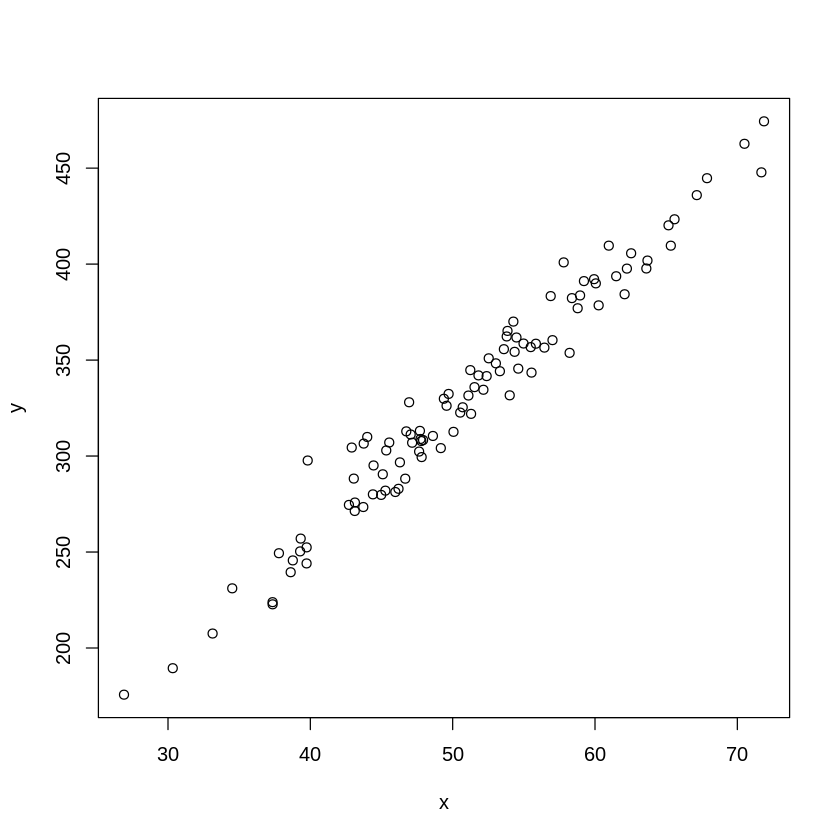

In [22]:
set.seed(123)  # Para reproducibilidad

# Generar 100 observaciones
n <- 100
x <- rnorm(n, mean = 50, sd = 10)          # Variable predictora
y <- 6.5 * x + rnorm(n, mean = 0, sd = 12) # Variable respuesta con ruido

plot(x,y)

datos <- data.frame(x = x, y = y)
head(datos)

# Introducir NA aleatoriamente en 15 valores de x
na_indices <- sample(1:n, size = 15)
datos$x[na_indices] <- NA

summary(datos)
colSums(is.na(datos))

#Intentamos ajustar el modelo
modelo_con_na <- lm(y ~ x, data = datos)
summary(modelo_con_na)

#R ajusta el modelo usando solo las filas donde y no es NA (complete-case analysis).

#Comprobémoslo:
nrow(datos)                # 100 observaciones originales
nrow(modelo_con_na$model)  # Solo 85 filas usadas (15 con NA en x)

#Miremos que pasa con el modelo al imputar, por ejemplo con la media
datos_imputados <- datos
datos_imputados$x[is.na(datos_imputados$x)] <- mean(datos$x, na.rm = TRUE)

modelo_imputado <- lm(y ~ x, data = datos_imputados)
summary(modelo_imputado)

nrow(datos_imputados)                # 100 observaciones originales
nrow(modelo_imputado$model)  # Solo 85 filas usadas (15 con NA en x)




## Detección y diagnóstico de valores faltantes

**¿por qué es tan crítico?**
Un solo NA sin tratar puede hacer que todo un análisis falle o se distorsione.

Los datos faltantes deben ser detectados, visualizados y tratados adecuadamente.

El primer paso siempre debe ser saber si alguna(s) de la(s) variables(s) contiene datos faltantes, para esto contamos con muchas herramientas, veremos algunas de ellas:

In [ ]:
#install.packages("naniar")
## Instalar paquetes de visualización de datos faltantes
#install.packages("visdat")
#install.packages("VIM")
## Instalar paquete en desarrollo de estimación de datos faltantes
#install.packages("remotes")
#remotes::install_github("davidbiol/empire")

library(naniar)
library(VIM)

Métodos para detectar NAs.

In [44]:
print("----- Para ver si hay NA --------")

summary(datos)

print("---- Número total de NA ---------")

sum(is.na(datos))

print("----- Número de NA por columna --------")

colSums(is.na(datos))

print("---- Número de NA por fila ---------")

rowSums(is.na(datos))

print("--- Devuelve TRUE si hay al menos un NA en el data.frame. Es la forma más rápida y directa. ----------")

anyNA(datos)

print("---- Devuelve una matriz lógica del mismo tamaño que datos, indicando con TRUE dónde hay NA. ---------")

is.na(datos)

print("---- Devuelve un vector lógico que indica qué filas no tienen ningún NA. Puedes usarlo para filtrar: ---------")

complete.cases(datos)

print("---- Muestra número y porcentaje de NA por fila ---------")

miss_case_summary(datos)







[1] "----- Para ver si hay NA --------"


       x               y        
 Min.   :26.91   Min.   :175.7  
 1st Qu.:45.33   1st Qu.:294.0  
 Median :50.71   Median :328.9  
 Mean   :51.03   Mean   :329.6  
 3rd Qu.:57.80   3rd Qu.:366.4  
 Max.   :71.87   Max.   :474.4  
 NA's   :15                     

[1] "---- Número total de NA ---------"


[1] 15

[1] "----- Número de NA por columna --------"


x  y 
15  0

[1] "---- Número de NA por fila ---------"


[1] 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1
 [38] 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0
 [75] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0

[1] "--- Devuelve TRUE si hay al menos un NA en el data.frame. Es la forma más rápida y directa. ----------"


[1] TRUE

[1] "---- Devuelve una matriz lógica del mismo tamaño que datos, indicando con TRUE dónde hay NA. ---------"


x,y
FALSE,FALSE
FALSE,FALSE
FALSE,FALSE
FALSE,FALSE
FALSE,FALSE
FALSE,FALSE


[1] "---- Devuelve un vector lógico que indica qué filas no tienen ningún NA. Puedes usarlo para filtrar: ---------"


[1]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE
 [13]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE  TRUE
 [25]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE FALSE
 [37] FALSE  TRUE FALSE  TRUE FALSE  TRUE FALSE FALSE  TRUE  TRUE  TRUE  TRUE
 [49]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [61] FALSE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE
 [73] FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [85]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE FALSE
 [97]  TRUE  TRUE  TRUE  TRUE

[1] "---- Muestra número y porcentaje de NA por fila ---------"


case,n_miss,pct_miss
<int>,<int>,<dbl>
9,1,50
22,1,50
23,1,50
31,1,50
36,1,50
37,1,50
39,1,50
41,1,50
43,1,50


Métodos de visualización:

[1] " -------   Muestra número y porcentaje de NA por variable. -------------"


variable,n_miss,pct_miss
<chr>,<int>,<num>
x,1,10
y,1,10


[1] "---- Muestra un gráfico de barras con la cantidad de valores faltantes por variable y patrones comunes. ---------"


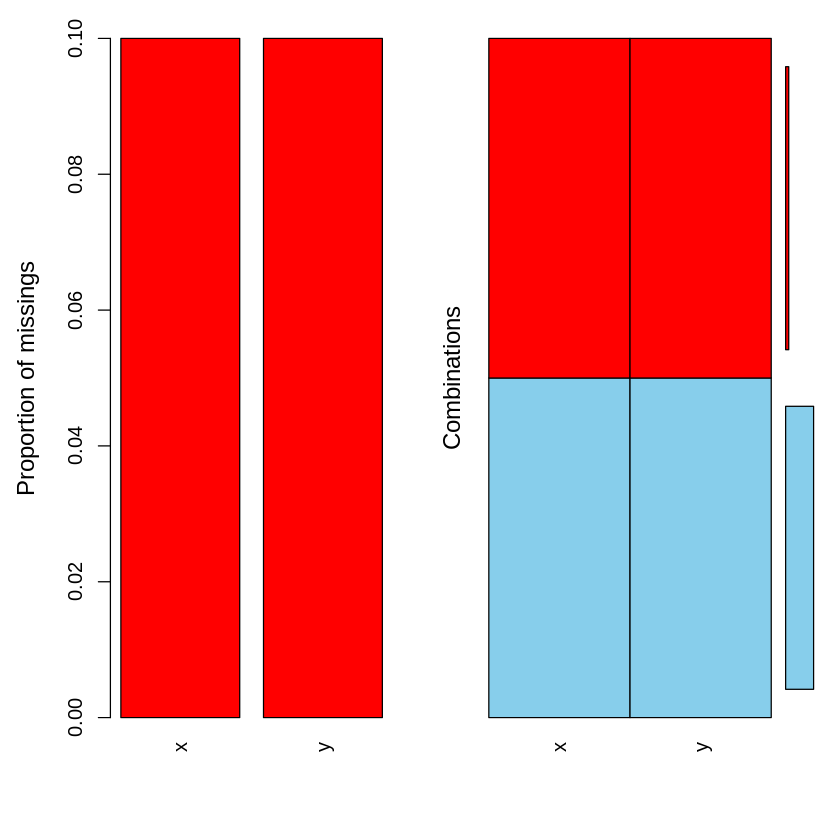

In [45]:
print(" -------   Muestra número y porcentaje de NA por variable. -------------")

miss_var_summary(df)

print("---- Muestra un gráfico de barras con la cantidad de valores faltantes por variable y patrones comunes. ---------")

aggr(df)

## Patrones de pérdida de datos

Los patrones describen *dónde* faltan los datos en el dataset. Los principales son:

<center>
 <img src="https://github.com/ednavivianasegura/AccesoImages/blob/main/datossinNA.png?raw=true" alt="descriptiva" width="50%" height="50%">  
</center>


- **Univariado**: solo una variable tiene NA:

<center>
 <img src="https://github.com/ednavivianasegura/AccesoImages/blob/main/UnivariadoNA.png?raw=true" alt="descriptiva" width="50%" height="50%">  
</center>

Solo una variable contiene valores faltantes; el resto de las variables están completamente observadas.
Suele ser el patrón más simple y fácil de manejar.

- **Multivariado (general)**:

<center>
 <img src="https://github.com/ednavivianasegura/AccesoImages/blob/main/MultivariadoNA.png?raw=true" alt="descriptiva" width="50%" height="50%">  
</center>


Varias variables contienen valores faltantes, sin seguir un orden estructurado. Es el patrón más común en la práctica.

Por ejemplo en un estudio poblacional, la edad, peso y ingresos tienen valores faltantes, pero distribuidos de forma irregular.

Suele representar más dificultad en la aplicación de algunos métodos clásicos (como imputación monótona).

- **Monótono**: si hay NA en una variable, también en todas las siguientes.

<center>
 <img src="https://github.com/ednavivianasegura/AccesoImages/blob/main/MonotonoNA.png?raw=true" alt="descriptiva" width="50%" height="50%">  
</center>

Hay un orden específico:
si una observación tiene un valor faltante en la variable Xj, entonces tendrá faltantes en todas las variables posteriores (Xj+1, Xj+2, ...).

Por ejemplo: si falta el peso, también faltan ingresos y presión, pero no edad.

Habitualmente, este patrón permite el uso de métodos de imputación secuenciales como regresión por pasos.

- **Arbitrario**: los valores faltantes aparecen en cualquier lugar, sin estructura visible ni lógica aparente. Es el caso más difícil de manejar.

<center>
 <img src="https://github.com/ednavivianasegura/AccesoImages/blob/main/GeneraNA.png?raw=true" alt="descriptiva" width="50%" height="50%">  
</center>

Este patrón suele requerir de métodos de imputación más robustos, como imputación múltiple o modelos bayesianos.






### Ejemplo práctico:

Veamos esto de una manera práctica con el dataset `sleep`. Este conjunto se basa en una recopilación de datos de sueño en mamíferos que apareció en el estudio R. M. Siegel (2005). Clues to the functions of mammalian sleep. Nature, 437(7063), 1264–1271. Cada fila representa una especie de mamífero. Y las variables describen: características biológicas (peso corporal, peso cerebral), comportamientos relacionados con el sueño (horas REM y no REM), estrategias de supervivencia (depredador, exposición al peligro) y riesgos ecológicos.

| Variable   | Tipo                | Descripción breve                                        |
| ---------- | ------------------- | -------------------------------------------------------- |
| `BodyWgt`  | numérico            | Peso corporal en kilogramos                              |
| `BrainWgt` | numérico            | Peso del cerebro en gramos                               |
| `NonD`     | numérico            | Horas de sueño no REM (sin movimientos oculares rápidos) |
| `Dream`    | numérico            | Horas de sueño REM (con sueños)                          |
| `Sleep`    | numérico            | Total de horas de sueño por día                          |
| `Span`     | numérico            | Esperanza de vida en años                                |
| `Gest`     | numérico            | Duración de la gestación en días                         |
| `Pred`     | categórica (factor) | ¿Es el animal un depredador? (categoría: sí/no)          |
| `Exp`      | categórica (factor) | ¿Está expuesto a peligro? (bajo, medio, alto)            |
| `Danger`   | numérico            | Nivel de peligro general (valor numérico del riesgo)     |



In [49]:
data(sleep)
# Ver dimensiones del dataset
dim(sleep)
 #Ver variables del dataset
str(sleep)



[1] 62 10

'data.frame':	62 obs. of  10 variables:
 $ BodyWgt : num  6654 1 3.38 0.92 2547 ...
 $ BrainWgt: num  5712 6.6 44.5 5.7 4603 ...
 $ NonD    : num  NA 6.3 NA NA 2.1 9.1 15.8 5.2 10.9 8.3 ...
 $ Dream   : num  NA 2 NA NA 1.8 0.7 3.9 1 3.6 1.4 ...
 $ Sleep   : num  3.3 8.3 12.5 16.5 3.9 9.8 19.7 6.2 14.5 9.7 ...
 $ Span    : num  38.6 4.5 14 NA 69 27 19 30.4 28 50 ...
 $ Gest    : num  645 42 60 25 624 180 35 392 63 230 ...
 $ Pred    : int  3 3 1 5 3 4 1 4 1 1 ...
 $ Exp     : int  5 1 1 2 5 4 1 5 2 1 ...
 $ Danger  : int  3 3 1 3 4 4 1 4 1 1 ...



 Variables sorted by number of missings: 
 Variable      Count
     NonD 0.22580645
    Dream 0.19354839
    Sleep 0.06451613
     Span 0.06451613
     Gest 0.06451613
  BodyWgt 0.00000000
 BrainWgt 0.00000000
     Pred 0.00000000
      Exp 0.00000000
   Danger 0.00000000


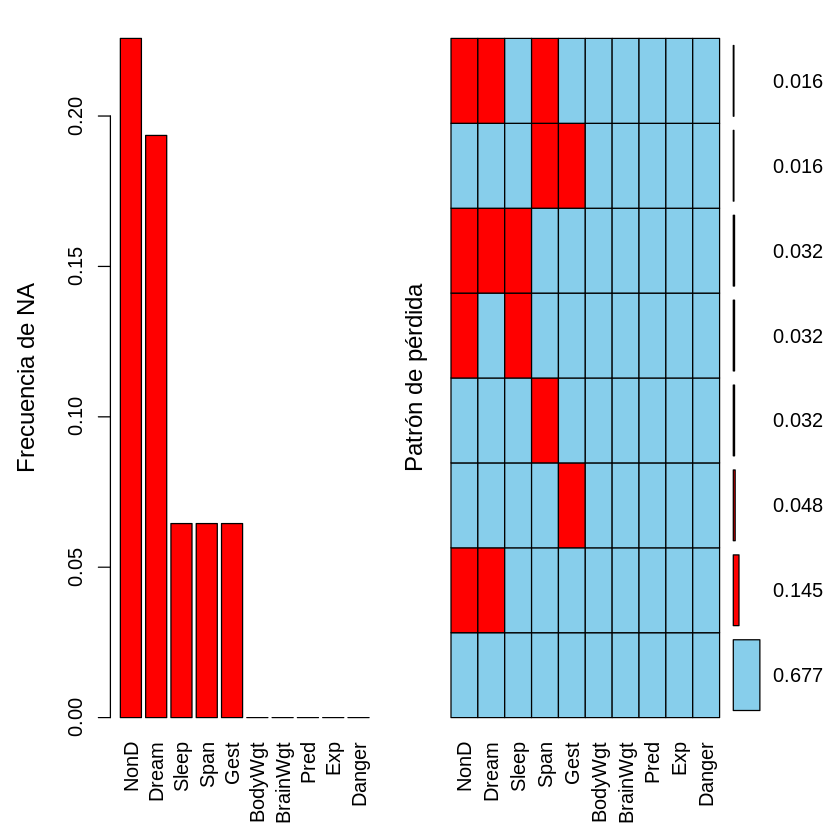

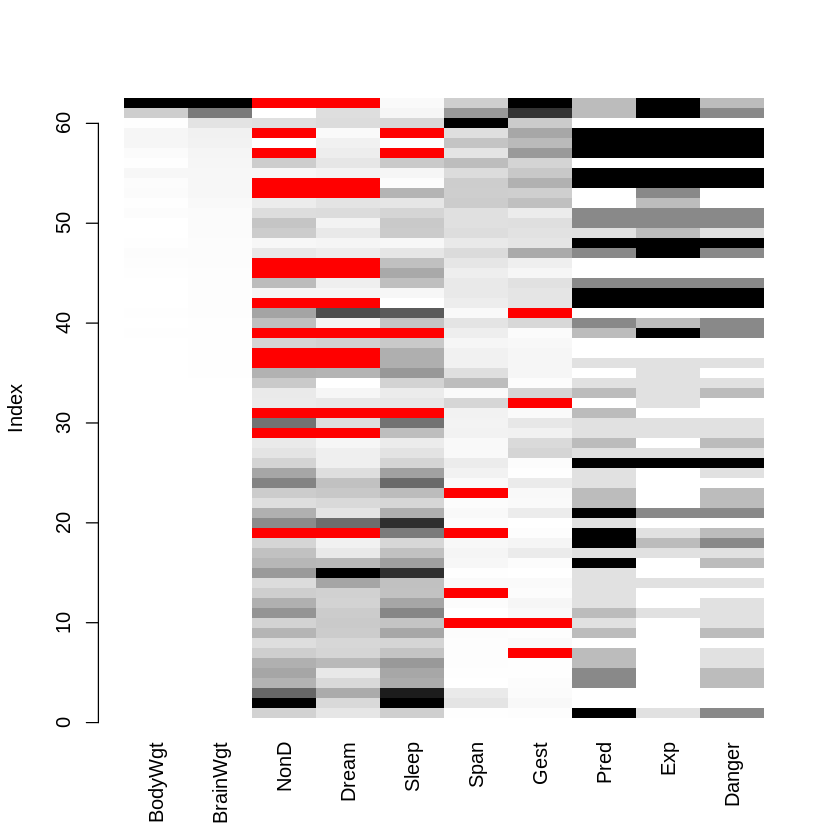

In [53]:
data(sleep, package = "VIM")

# Visualizar patrón general
aggr(sleep, numbers = TRUE, sortVars = TRUE, gap = 3,
     ylab = c("Frecuencia de NA", "Patrón de pérdida"))

# También útil: matriz de patrones
matrixplot(sleep, sortby = 2)




# 4. Mecanismos de pérdida de datos: MCAR, MAR y MNAR

## MCAR: Missing Completely At Random


# La probabilidad de pérdida es completamente aleatoria. No depende de otras variables.


## MAR: Missing At Random


# La pérdida depende de variables observadas (ej. edad), pero no del valor faltante.


## MNAR: Missing Not At Random

# La pérdida depende del valor perdido en sí mismo (no observable directamente).